In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import DataSplitter
import utils
import matplotlib.pyplot as plt
import copy

In [23]:
def selectFeatures(X_train, X_val, lags, exog):
    columns_to_keep = []
    if len(lags) == 0 and not exog:
        print("No data")
        return np.nan, np.nan
    
    for col in X_train.columns:
        if col.startswith(lagColName):
            if int(col[len(lagColName):]) in lags:
                columns_to_keep.append(col)
        elif exog:
            columns_to_keep.append(col)

    return X_train[columns_to_keep], X_val[columns_to_keep]

# Change accordingly
diff = False
lags = [1, 4, 8, 20, 40, 120, 140]  # [i+1 for i in range(20)] + [40, 60, 80, 100, 120, 140]  # <-- To use all columns
exog = True

if diff:
    # Input diff, output diff
    target_column = "diff"
    drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]
    lagColName = "diffLag"
    
if not diff:
    # Input passengers, output passengers
    target_column = "passengersBoarding"
    drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "datetime", "eventName"]
    lagColName = "lag"

df60 = DataSplitter.getTrainData(60, diff=diff)

train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"]
val60_1A = val60[val60["line"] == "1A"]

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)

X_train, X_val = selectFeatures(X_train, X_val, lags=lags, exog=exog)

In [3]:
batchSize = 32  # len(X_train)//20

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)

valDataset = TensorDataset(X_val_tensor, y_val_tensor)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

In [4]:
def evaluation(model, loader, criterion, device):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_idx, (Xbatch, ybatch) in enumerate(loader):
            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)
                
            predictions = model(Xbatch.unsqueeze(-1)).squeeze()

            loss = criterion(predictions, ybatch)
            total_loss.append(loss.item())
    return np.mean(total_loss)

In [5]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


In [73]:
def train_NN(model, trainLoader, valLoader, totalEpochs=100, lr=1e-3, device="cpu", save_loss=False, save_best=False, reestimate=False):
    device = torch.device(device)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction="mean")

    train_loss_list = []
    val_loss_list = []
    nEpochs = range(1, totalEpochs + 1)
    best_val_loss = np.inf
    for epoch in nEpochs:
        model.train()
        total_loss = []
        for batch_idx, (Xbatch, ybatch) in enumerate(trainLoader):
            optimizer.zero_grad()

            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)

            predictions = model(Xbatch.unsqueeze(-1)).squeeze()

            loss = criterion(predictions, ybatch)
                
            loss.backward()

            optimizer.step()

            total_loss.append(loss.item())

        total_loss_mean = np.mean(total_loss)
        train_loss_list.append(total_loss_mean)

        val_loss_mean = evaluation(model, valLoader, criterion, device)
        val_loss_list.append(val_loss_mean)

        if val_loss_mean < best_val_loss and save_best:
            best_model = copy.deepcopy(model)
            best_val_loss = val_loss_mean

        if epoch % 10 == 0 and not reestimate:
            print(f"Epoch: {epoch}, Train Loss: {total_loss_mean}, Val Loss: {val_loss_mean}")

    train_loss_list = np.array(train_loss_list)
    val_loss_list = np.array(val_loss_list)

    if save_loss:
        np.save(train_loss_list, "train_loss.npy")
        np.save(val_loss_list, "val_loss.npy")
    if save_best:
        model = copy.deepcopy(best_model)
        
    model = model.to("cpu")

    return model, nEpochs, train_loss_list, val_loss_list

#model, nEpochs, train_loss_list, val_loss_list = train_NN(LSTM(), trainLoader, valLoader, totalEpochs=20, lr=1e-3, device="cuda")

In [78]:
from IPython.display import clear_output

def scaleData(X_train, y_train, X_val, y_val):
    scaler_X = StandardScaler()  # Initialize a scaler_X
    X_train_scaled = scaler_X.fit_transform(X_train)                    # scaler_X is fitted to the columns of X_train
    X_val_scaled = scaler_X.transform(X_val)                            # scaler_X is used to transform the columns of X_val
    X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)  # The scaled values are then type np.array. We also save as dataframe
    X_val_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)        # for both train and val

    scaler_y = StandardScaler()  # Initialize a scaler_y
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # scaler_y is fittet to y_train
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))          # scaler_y is used to transform y_val

    return scaler_X, scaler_y, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, X_train_df, X_val_df


def createTensors(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled):
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor


def createDataLoaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batchSize):
    trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)
    valDataset = TensorDataset(X_val_tensor, y_val_tensor)
    valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

    return trainLoader, valLoader


def removeGTLags(col, lagColName):
    if lagColName in col.name:
        lag = int(col.name[len(lagColName):])
        col.loc[lag:] = np.nan


def updateLagsWithRealValues(col, lagColName, realValues, horizon):
    if lagColName in col.name:
        latest_realValues = realValues[:horizon]
        lag = int(col.name[len(lagColName):])

        start_val = np.max([0, lag - horizon])
        end_val = np.min([lag, horizon])
        for i in range(end_val):
            col.iloc[(start_val+i):(start_val+i+1)] = latest_realValues[-(end_val-i)]


def predictHorizonSteps(X_val_df, y_val_pred_scaled, model, horizon):
    steps = np.min([horizon, len(X_val_df)])  # Find how many steps to forecast (always length of horizon except for last iteration)
    for _ in range(0, steps):
        X_fit_tensor = torch.FloatTensor(X_val_df.iloc[0:1].values)  # Select the first row in the validation set and turn it into tensor
        y_val_pred_scaled.append(model(X_fit_tensor.unsqueeze(-1)).detach().squeeze().numpy().tolist())  # Use the estimated model to predict the next value from the first row tensor, and add it to predictions

        X_val_df = X_val_df.apply(lambda col: col.fillna(y_val_pred_scaled[-1], limit=1))             # Add the next row in each lag column
        X_val_df = X_val_df.drop(X_val_df.index[0]).reset_index(drop=True)  # Drop the row that was just used and reset the index of the dataframe

    return X_val_df, y_val_pred_scaled


def fixedWindowPytorch(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, model, batchSize, epochs, lr, device, horizon):
    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, model


def expandingWindowPytorch(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, model, batchSize, epochs, lr, device, horizon):
    # Add the next <horizon> predicted steps of validation data to the training data and remove it from the validation data
    X_train_tensor = torch.cat((X_train_tensor, X_val_tensor[:horizon]), dim=0)
    X_val_tensor = X_val_tensor[horizon:]
    y_train_tensor = torch.cat((y_train_tensor, y_val_tensor[:horizon]), dim=0)
    y_val_tensor = y_val_tensor[horizon:]

    # Turn the updated tensors into dataloaders
    trainLoader, _ = createDataLoaders(X_train_tensor,
                                       y_train_tensor,
                                       X_val_tensor,
                                       y_val_tensor,
                                       batchSize=batchSize)
    
    # Reestimate NN model from training data + next <horizon> predicted steps of validation data
    reestimated_model, _, _, _ = train_NN(model,
                                          trainLoader,
                                          totalEpochs=epochs,
                                          lr=lr,
                                          device=device,
                                          save_best=False,
                                          reestimate=True)

    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, reestimated_model


def rollingWindowPytorch(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, model, batchSize, epochs, lr, device, horizon):
    # Add the next <horizon> predicted steps of validation data to the training data, remove it from the validation data and remove the first <horizon> steps of training data
    X_train_tensor = torch.cat((X_train_tensor, X_val_tensor[:horizon]), dim=0)
    X_val_tensor = X_val_tensor[horizon:]
    X_train_tensor = X_train_tensor[horizon:]
    y_train_tensor = torch.cat((y_train_tensor, y_val_tensor[:horizon]), dim=0)
    y_val_tensor = y_val_tensor[horizon:]
    y_train_tensor = y_train_tensor[horizon:]

    # Turn the updated tensors into dataloaders
    trainLoader, _ = createDataLoaders(X_train_tensor,
                                       y_train_tensor,
                                       X_val_tensor,
                                       y_val_tensor,
                                       batchSize=batchSize)
    
    # Reestimate NN model from training data + next <horizon> predicted steps of validation data
    reestimated_model, _, _, _ = train_NN(model,
                                          trainLoader,
                                          totalEpochs=epochs,
                                          lr=lr,
                                          device=device,
                                          save_best=False,
                                          reestimate=True)

    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, reestimated_model


def forecast(windowStrategy, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_val_df, y_gt, model, batchSize, epochs, lr, device, lagColName, horizon):
    y_val_pred_scaled = []  # Initialize a prediction list for predictions
    iterations = 0  # Keep track of iterations

    # While there is still values left in the validation set to be forecasted
    while len(X_val_df) != 0:
        # Update iteration and print
        iterations += 1
        print(iterations)
        clear_output(wait=True)

        # Predict the next <horizon> values and update the lags of the input data with the predicted values
        X_val_df, y_val_pred_scaled = predictHorizonSteps(X_val_df,
                                                          y_val_pred_scaled,
                                                          model=model,
                                                          horizon=horizon)

        # After forecasting the steps
        X_val_df.apply(updateLagsWithRealValues, lagColName=lagColName, realValues=y_gt, horizon=horizon)  # Call the updateLagsWithRealValues function on all columns, which inserts the ground truth values in the lags instead of the predicted values
        y_gt = y_gt[horizon:]  # Remove the <horizon> ground truth values that have been inserted into the lags

        # Change model according to the used window strategy
        X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, model = windowStrategy(X_train_tensor,
                                                                                           y_train_tensor,
                                                                                           X_val_tensor,
                                                                                           y_val_tensor,
                                                                                           model=model,
                                                                                           batchSize=batchSize,
                                                                                           epochs=epochs,
                                                                                           lr=lr,
                                                                                           device=device,
                                                                                           horizon=horizon)

    return y_val_pred_scaled


def forecastPytorch(windowStrategy, X_train, y_train, X_val, y_val, model, batchSize, epochs, lr, device, lagColName, horizon):

    _, scaler_y, X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, _, X_val_df = scaleData(X_train,
                                                                                                     y_train,
                                                                                                     X_val,
                                                                                                     y_val)

    # Turn the scaled lists into tensors
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = createTensors(X_train_scaled,
                                                                               y_train_scaled,
                                                                               X_val_scaled,
                                                                               y_val_scaled)

    # Turn the tensors into dataloaders
    initial_trainLoader, initial_valLoader = createDataLoaders(X_train_tensor,
                                                               y_train_tensor,
                                                               X_val_tensor,
                                                               y_val_tensor,
                                                               batchSize=batchSize)

    # Estimate NN model from training data
    estimated_model, epoch_range, train_loss_list, val_loss_list = train_NN(model,
                                                                            initial_trainLoader,
                                                                            initial_valLoader,
                                                                            totalEpochs=epochs,
                                                                            lr=lr,
                                                                            device=device,
                                                                            save_best=False)
    
    # Get fitted values from train
    y_train_pred_scaled = estimated_model(X_train_tensor.unsqueeze(-1)).detach().squeeze().numpy().tolist()

    X_val_df.apply(removeGTLags, lagColName=lagColName)  # Calls the removeGTLags function on all columns, which removes the lags that would not yet be known from the starting point of the forecasting
    y_gt = y_val_scaled.squeeze().tolist()  # Initiate y_gt as the ground truth observations

    y_val_pred_scaled = forecast(windowStrategy,
                                 X_train_tensor,
                                 y_train_tensor,
                                 X_val_tensor,
                                 y_val_tensor,
                                 X_val_df,
                                 y_gt,
                                 model=copy.deepcopy(estimated_model),
                                 batchSize=batchSize,
                                 epochs=epochs,
                                 lr=lr,
                                 device=device,
                                 lagColName=lagColName,
                                 horizon=horizon)
    
    # Inverse transform the scaled predictions and output as type pd.Series
    y_train_pred = pd.Series(scaler_y.inverse_transform(np.array(y_train_pred_scaled).reshape(-1, 1)).squeeze())
    y_val_pred = pd.Series(scaler_y.inverse_transform(np.array(y_val_pred_scaled).reshape(-1, 1)).squeeze())
    return estimated_model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list

In [75]:
model = LSTM(hidden_size=100, num_layers=2, dropout_prob=0.35, bidirectional=True)
model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = forecastPytorch(fixedWindowPytorch,
                                                                                               X_train,
                                                                                               y_train,
                                                                                               X_val,
                                                                                               y_val,
                                                                                               model=model,
                                                                                               batchSize=32,
                                                                                               epochs=40,
                                                                                               lr=1e-3,
                                                                                               device=device,
                                                                                               lagColName=lagColName,
                                                                                               horizon=40)

46


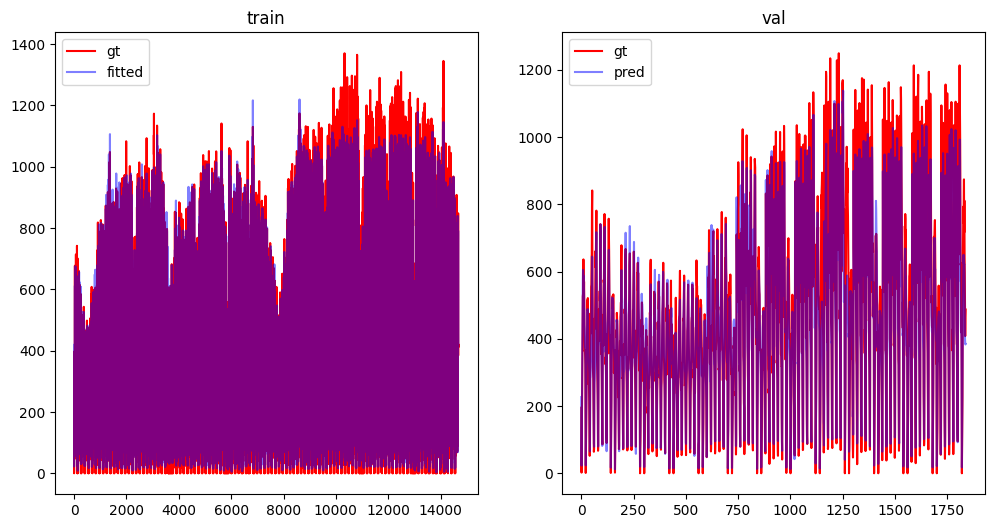

train MAE%: 0.094
train MAPE: 0.155
train RMSE%: 0.125
val MAE%: 0.116
val MAPE: 0.183
val RMSE%: 0.169


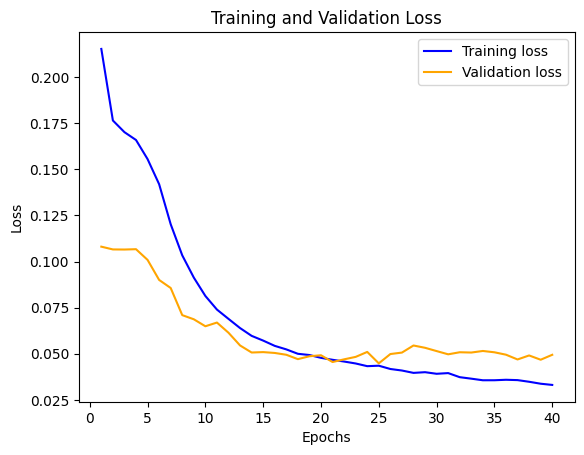

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(y_train.index, y_train, color='red', label='gt')
ax[0].plot(y_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
ax[0].set_title('train')
ax[0].legend()

ax[1].plot(y_val.index, y_val, color='red', label='gt')
ax[1].plot(y_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
ax[1].set_title('val')
ax[1].legend()
plt.show()

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(epoch_range, train_loss_list, color='blue', label='Training loss')
plt.plot(epoch_range, val_loss_list, color='orange', label='Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# test to handle differencing
period = 40
val60_line_extended = pd.concat([train60_1A['passengersBoarding'].tail(period), val60_1A['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_1A['diff'].tail(period), y_val_pred], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

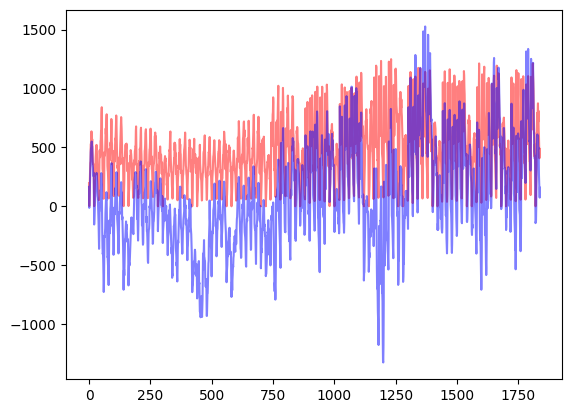

In [ ]:
plt.plot(val60_1A["passengersBoarding"].reset_index(drop=True), color="red", alpha=0.5)
plt.plot(y_val_pred_passengers.reset_index(drop=True), color="blue", alpha=0.5)

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM